# Finite Difference Approximations

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [1]:
import jax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

## Measuring Order of Accuracy

When we come up with a finite difference equation for approximating a derivative, we often want to know how accurate it is. To do this theoretically, we can express each point in the finite difference equation as a Taylor series, and then combine them to get a Taylor series for the finite difference equation. As explained in the course notes, this should leave us with the derivative term we want to approximate plus a truncation error that is proportional to the step size raised to some power. e.g, for a central difference approximation of the first derivative, we have:

$$\frac{f(x+\Delta x) - f(x-\Delta x)}{2 \Delta x} = \frac{df}{dx} + \mathcal{O}(\Delta x^2)$$

This means that (for small enough $\Delta x$) the error in the finite difference approximation should scale with $\Delta x^2$, which makes this central difference approximation a second order accurate method.

We can use this theoretical order of accuracy to check that a finite difference scheme we implement in code is working correctly. To do this, we use the finite difference scheme to approximate the derivative of a function that we know the true derivative of and then plot the error as a function of $\Delta x$. If we plot the error on a log-log scale, the slope of the line should be equal to the order of accuracy of the scheme.

$$\tau(\Delta x) = C \Delta x^p \Rightarrow \log{\tau(\Delta x)} = \log{C} + p \log{\Delta x}$$

In the code below we experimentally validate the order of accuracy of the forward, backward, and central-difference approximations of the first derivative.

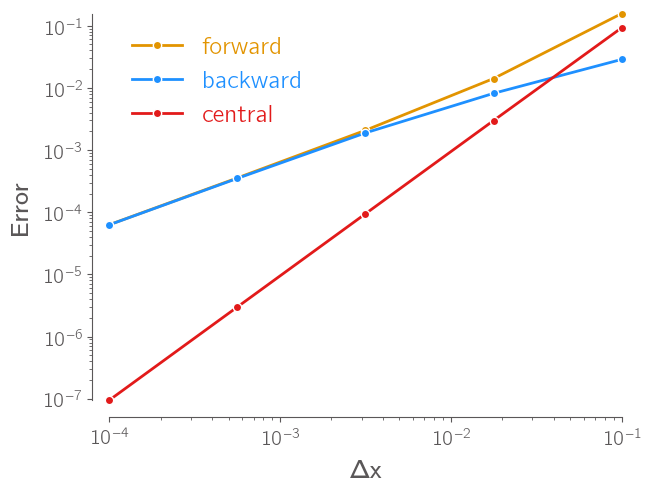

In [10]:
# Define the analytic function (e.g., sin(x))
def analytic_function(x):
    return 1 + jnp.sin(2*x)**3

# Define the forward difference approximation for the first derivative
def forward_difference(f, x, h):
    return (f(x + h) - f(x)) / h

# Define the forward difference approximation for the first derivative
def backward_difference(f, x, h):
    return (f(x) - f(x - h)) / h

# Define the forward difference approximation for the first derivative
def central_difference(f, x, h):
    return (f(x + h) - f(x - h)) / (2 * h)

# Define a range of step sizes from 10^-1 to 10^-4
step_sizes = [10**(-n) for n in jnp.linspace(1,4,5)]

# Define the point at which to evaluate the derivative (e.g., 0.5)
x_point = 0.5

# Calculate the true derivative using grad
true_derivative = jax.grad(analytic_function)(x_point)

# Use a dictionary to store the functions and the errors for each finite difference scheme
FD_functions = {"forward":forward_difference, "backward":backward_difference, "central":central_difference}
FD_errors = {"forward":[], "backward":[], "central":[]}
FD_convergence_orders = {"forward":[], "backward":[], "central":[]}

# Create a figure and axis to plot on
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("$\Delta x$")
ax.set_ylabel("Error")

# Calculate errors for each step size and finite difference scheme
for FD_name, FD_function in FD_functions.items():
    for h in step_sizes:
        approx_derivative = FD_function(analytic_function, x_point, h)
        error = jnp.abs(approx_derivative - true_derivative)
        FD_errors[FD_name].append(error)

    # Plot the errors
    ax.plot(step_sizes, FD_errors[FD_name], marker='o', linestyle='-', clip_on=False, label=FD_name)

    # Calculate the convergence order by measuring the slope of the log-log plot
    for i in range(1, len(FD_errors[FD_name])):
        FD_convergence_orders[FD_name].append(jnp.log(FD_errors[FD_name][i-1] / FD_errors[FD_name][i]) / jnp.log(step_sizes[i-1] / step_sizes[i]))

niceplots.adjust_spines(ax)
ax.legend(labelcolor="linecolor")
# Plot error vs. step size on a log-log scale
# plt.figure()
# plt.loglog(step_sizes, errors_f, marker='o', linestyle='-')
# plt.loglog(step_sizes, errors_b, marker='o', linestyle='-')
# plt.loglog(step_sizes, errors_c, marker='o', linestyle='-')

# # Add slope information to the legend
# for i in range(len(order_f)):
#     plt.text(step_sizes[i], errors_f[i], f"Order {order_f[i]:.2f}", fontsize=10, ha='left', va='top')
#     plt.text(step_sizes[i], errors_b[i], f"Order {order_b[i]:.2f}", fontsize=10, ha='left', va='top')
#     plt.text(step_sizes[i], errors_c[i], f"Order {order_c[i]:.2f}", fontsize=10, ha='left', va='top')

# # Label the plot
# plt.xlabel('Step Size (h)')
# plt.ylabel('Error')
# plt.title('Error vs. Step Size (Log-Log Scale)')

# # Show the plot
# plt.grid()
# plt.legend(["Forward","Backward","Central"])
# plt.show()

Lagrange Interpolating Polynomial

In [3]:
import jax
import jax.numpy as jnp

def lagrange_interpolation(x, y):
    """
    Calculate the Lagrange interpolating polynomial.

    Parameters:
    x (jax.numpy.ndarray): Array of x-values.
    y (jax.numpy.ndarray): Array of corresponding y-values.

    Returns:
    callable: The Lagrange interpolating polynomial as a callable function.
    """
    def L(k, xx):
        """Lagrange basis polynomial L_k(x)."""
        numerator = 1.0
        denominator = 1.0
        for i in range(len(x)):
            if i != k:
                numerator *= xx - x[i]
                denominator *= x[k] - x[i]
        return numerator / denominator

    def lagrange_polynomial(xx):
        """Lagrange interpolating polynomial P(x)."""
        result = 0.0
        for k in range(len(x)):
            result += y[k] * L(k, xx)
        return result


    return lagrange_polynomial

Plotting Lagrange functions

In [4]:
import matplotlib.pyplot as plt

L = 1
x_data = jnp.array([0.0, 1.0, 2.0, 3.0])/3
y0 = jnp.array([1.0, 0.0, 0.0, 0.0])
y1 = jnp.array([0.0, 1.0, 0.0, 0.0])
y2 = jnp.array([0.0, 0.0, 1.0, 0.0])
y3 = jnp.array([0.0, 0.0, 0.0, 1.0])

Np=200
xp = jnp.linspace(0,L,Np)

# Generating the Lagrange Interpolating Polynomials
L0 = lagrange_interpolation(x_data, y0)
L1 = lagrange_interpolation(x_data, y1)
L2 = lagrange_interpolation(x_data, y2)
L3 = lagrange_interpolation(x_data, y3)

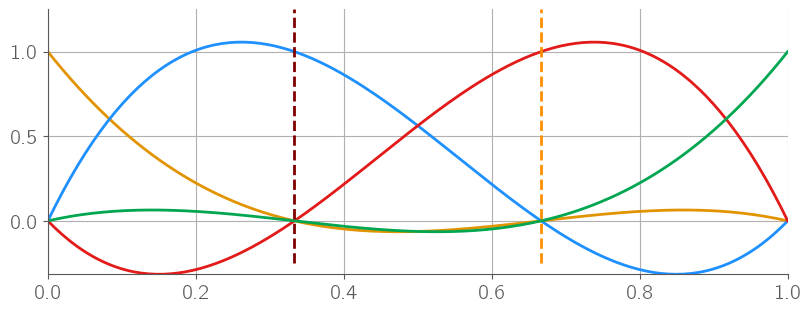

In [5]:
plt.figure(figsize = (8,3))
plt.plot(xp,L0(xp),xp,L1(xp),xp,L2(xp),xp,L3(xp), linewidth=2)
plt.grid()
# Mark the Node points
plt.plot([1/3,1/3],[-0.25,1.25],'--')
plt.plot([2/3,2/3],[-0.25,1.25],'--')